In [1]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
!ls ../..

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import preproc_ecg as pecg
import numpy as np

ptb_tdir = '/scratch/arka/Ark_git_files/ecg_data/'
ptb_ptdir = ptb_tdir + 'patient_data/'

records = pd.read_csv(ptb_tdir + 'records.txt', header=None)
controls = pd.read_csv(ptb_tdir + 'control.txt', header=None)

In [4]:
reco = records[0]
co = controls[0]

In [5]:
r = reco[0]
c = co[0]

In [6]:
r2  = wfdb.rdrecord(ptb_ptdir + r)

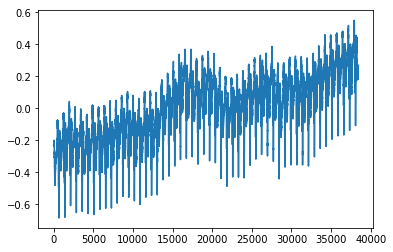

In [7]:
plt.plot(r2.p_signal[:, 1])

In [8]:
r1 = wfdb.rdrecord(ptb_ptdir + r)
c1 = wfdb.rdrecord(ptb_ptdir + c)

In [9]:
c1.p_signal[:,0].max()

0.7435

In [10]:
sig = r1.p_signal
sig_ds = sig[np.arange(0, sig.shape[0], 4), :]
sig_bp = pecg.bp_filt(sig_ds)
_, peak_locs = pecg.pan_tompkins_r_detection(sig_bp[:, 6], fs=200)
sig_partitioned_p1 = pecg.partition_signal(sig_bp, peak_locs[1:-1])

100%|██████████| 50/50 [00:00<00:00, 188085.38it/s]


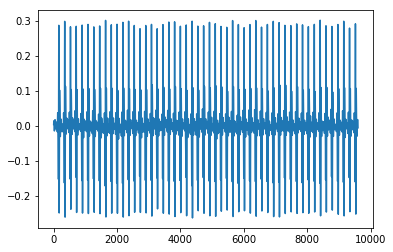

In [11]:
plt.plot(sig_bp[:, 0])

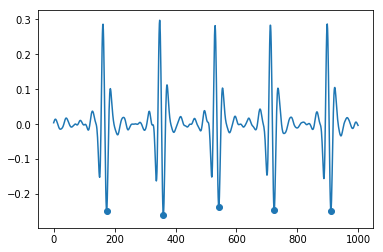

In [12]:
plt.plot(sig_bp[:1000, 0])
p1locs = np.array(peak_locs)[np.where(np.array(peak_locs)<1000)]
plt.scatter(p1locs, sig_bp[:1000, 0][p1locs])

In [14]:
sig = c1.p_signal
sig_ds = sig[np.arange(0, sig.shape[0], 4), :]
sig_bp = pecg.bp_filt(sig_ds)
_, peak_locs = pecg.pan_tompkins_r_detection(sig_bp[:, 6], fs=200)
sig_partitioned_c1 = pecg.partition_signal(sig_bp, peak_locs[1:-1])

100%|██████████| 117/117 [00:00<00:00, 372614.71it/s]


In [15]:
sig_partitioned_p1.shape

(50, 149, 15)

In [16]:
plt.close()

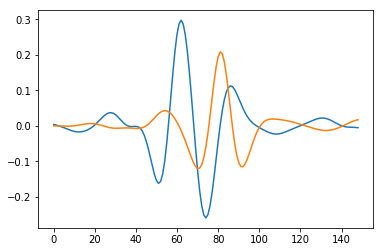

In [17]:
plt.plot(sig_partitioned_p1[0, :, 0])
plt.plot(sig_partitioned_c1[0, :, 0])

In [ ]:
for i in range(sig_partitioned_p1.shape[0]):
    plt.plot(sig_partitioned_p1[i, :, 0])
# for i in range(sig_partitioned_c1.shape[0]):
#     plt.plot(sig_partitioned_c1[i, :, 0])

In [ ]:
r1.comments[5].split(':')[-2].strip()

In [ ]:
records_df = pd.DataFrame(records)

In [ ]:
# records_df.insert(1, 'Disease', [wfdb.rdsamp(ptb_ptdir + r).comments[4].split(':')[-1].strip() for r in reco])
records_df.insert(2, 'Localization', [wfdb.rdsamp(ptb_ptdir + r).comments[5].split(':')[-1].strip() for r in reco])

In [ ]:
records_df

In [ ]:
records_df.iloc[519]

In [ ]:
records_new_df = records_df[records_df['Disease'] != 'n/a']

In [ ]:
records_new_df

In [ ]:
records_new_df['Loc_Disease'] = records_new_df[['Disease', 'Localization']].apply(lambda x: '|'.join(x), axis=1)

In [ ]:
records_new_df['Loc_Disease'].apply(lambda x: x)

In [ ]:
records_new_df['Loc_Disease_label'] = records_new_df['Loc_Disease'].apply(lambda x: loc_disease_dict[x])

In [ ]:
records_new_df

In [ ]:
l1 = records_new_df['Loc_Disease'].unique()

In [ ]:
loc_disease_dict = {}
for ind, l in enumerate(l1):
    loc_disease_dict[l] = ind

In [ ]:
loc_disease_dict

In [ ]:
records_new_df

In [ ]:
train, validate, test = np.split(records_new_df.sample(frac=1), [int(.6*len(records_new_df)), int(.8*len(records_new_df))])

In [ ]:
train.groupby(['Disease']).count()

In [ ]:
validate.groupby(['Disease']).count()

In [ ]:
test.groupby(['Disease']).count()

In [ ]:
ls

In [ ]:
train.insert()

In [ ]:
train.to_csv('train.csv')
validate.to_csv('val.csv')
test.to_csv('test.csv')

In [ ]:
?json.dump

In [ ]:
import json
json.dump(loc_disease_dict,open('locdisease_map.json', 'w'))

In [ ]:
inv_locdise_map = {v: k for k, v in loc_disease_dict.items()}

In [ ]:
json.dump(inv_locdise_map, open('inv_locdisease_map.json', 'w'))

In [ ]:
def get_beats(sig):
    sig_ds = sig[np.arange(0, sig.shape[0], 4), :]
    sig_bp = pecg.bp_filt(sig_ds)
    _, peak_locs = pecg.pan_tompkins_r_detection(sig_bp[:, 6], fs=200)
    sig_partitioned_c1 = pecg.partition_signal(sig_bp, peak_locs[1:-1])
    return sig_partitioned_c1

In [ ]:
from tqdm import tqdm

In [ ]:
for r in tqdm(reco):
    p_record = wfdb.rdsamp(ptb_ptdir + r)
    beats = get_beats(p_record.p_signals)
    fname = '_'.join(r.split('/'))
    np.save('./beats_data/' + fname + '_beats.npy', beats)